<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/Anomaly_Detection_in_A_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# You can <font color="red"> **watch** </font>  this notebook at [Murat Karakaya Akademi channel on YOUTUBE!](https://www.youtube.com/watch?v=7MhZ2DDg89Y)



# Anomaly Detection in Time Series using Voting Scheme

In this notebook, we will predict if a GPS tracking device consumes **abnormal** amounts of current from the car battery (accumulator).

**Keywords & Concepts**:
* **Abnormal**: deviating from what is normal or usual, typically in a way that is undesirable or worrying.

* **Anomaly**: something that deviates from what is standard, normal, or expected.

* **Ensemble**: Ensemble methods are techniques that create multiple models and then combine them to produce improved results. 

* **Voting Scheme**: Voting is one of the easiest ensemble methods. the first step is to create multiple classification/regression models using some training dataset. Each base model can be created using different splits of the same training dataset and same algorithm, or using the same dataset with different algorithms, or any other method. 

* **Majority Voting**: Every model makes a prediction (votes) for each test instance and the final output prediction is the one that receives more than half of the votes. If none of the predictions get more than half of the votes, we may say that the ensemble method could not make a stable prediction for this instance. Although this is a widely used technique, you may try the most voted prediction (even if that is less than half of the votes) as the final prediction. 

* **Weighted Voting**: Unlike majority voting, where each model has the same rights, we can increase the importance of one or more models. In weighted voting you count the prediction of the better models multiple times. Finding a reasonable set of weights is up to you.





#  Data Collection & Preprocessing

A car tracking company collects the data automatically.
Car battery (accumulator) supplies the electric to the tracking device and tracking device logs electric supply in in miliamperes (mA). The number of the logs during a day varies according to the usage of the car. 

For simplify the problem, we selected one car with a diminishing battery (accumulator). Then, we processed the data such that for each day we have minimum and maximum  of the recorded current values.

# Goal

Our goal is to find the anomalies in the electric consumption due to battery or tracking device malfunction.



# Method
We will use an **ensembling** with **Majority Voting** implementing 4 prediction methods:
* [Facebook's Prophet](https://facebook.github.io/prophet/) 
* [Anomaly Detection with the Normal Distribution](https://anomaly.io/anomaly-detection-normal-distribution/index.html)
* [Simple Moving Average](https://towardsdatascience.com/anomaly-detection-def662294a4e) 
* [Exponential Moving Average](https://towardsdatascience.com/anomaly-detection-def662294a4e)

## NOTES:
* You can acess the notebook on  [COLAB](https://colab.research.google.com/drive/1Q9KPbgEXHbcJqUmsilPZntbtkGxSFdyA?usp=sharing), [GITHUB](https://github.com/kmkarakaya/ML_tutorials/blob/master/Anomaly_Detection_in_A_Time_Series.ipynb), or [Kaggle](https://www.kaggle.com/kmkarakaya/anomaly-detection-in-time-series-using-voting) 

* you can watch it on [YOUTUBE](https://www.youtube.com/watch?v=7MhZ2DDg89Y) 

* you can download the data from [GITHUB](https://github.com/kmkarakaya/ML_tutorials/blob/master/data/Min-Max%20Daily%20Analyse.csv) or [Kaggle](https://www.kaggle.com/kmkarakaya/car-battery-measurements)

* prepared by Murat Karakaya

## Load data

Let's begin with importing dependicies and data.

In [0]:
import pandas as pd
# prophet by Facebook
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from IPython.display import HTML



In [0]:
pd.set_option('display.max_columns', None)

In [0]:
url = 'https://raw.githubusercontent.com/kmkarakaya/ML_tutorials/master/data/Min-Max%20Daily%20Analyse.csv'
df = pd.read_csv(url, sep=';')
df.head()

,Date,Min,Max
0,6.2.2020,11.53,14.48
1,7.2.2020,9.13,14.56
2,8.2.2020,12.00,12.25
3,9.2.2020,11.96,12.00
4,10.2.2020,11.94,14.89


## Create New Feature

In [0]:
df['Range'] = df['Max']-df['Min']
df.head()

,Date,Min,Max,Range
0,6.2.2020,11.53,14.48,2.95
1,7.2.2020,9.13,14.56,5.43
2,8.2.2020,12.00,12.25,0.25
3,9.2.2020,11.96,12.00,0.04
4,10.2.2020,11.94,14.89,2.95


## Add meta data


In [0]:
import datetime 
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['Day'] = [ day_name[i] for i in pd.to_datetime(df['Date']).dt.dayofweek]
df= df[['Date','Day','Min','Max','Range']]
df.head()

,Date,Day,Min,Max,Range
0,6.2.2020,Tuesday,11.53,14.48,2.95
1,7.2.2020,Thursday,9.13,14.56,5.43
2,8.2.2020,Sunday,12.00,12.25,0.25
3,9.2.2020,Wednesday,11.96,12.00,0.04
4,10.2.2020,Friday,11.94,14.89,2.95


## Explore Data



In [0]:
df.describe()

,Min,Max,Range
count,90.000000,90.000000,90.000000
mean,11.510000,12.716444,1.206444
std,1.012351,1.082936,1.598325
min,7.200000,11.460000,0.040000
25%,11.462500,11.970000,0.122500
50%,11.800000,12.310000,0.250000
75%,12.072500,12.625000,2.260000
max,12.390000,14.890000,6.270000


In [0]:
df.corr(method ='pearson') 

,Min,Max,Range
Min,1.000000,-0.162836,-0.743711
Max,-0.162836,1.000000,0.780682
Range,-0.743711,0.780682,1.000000


## Visualize the data in a plot.


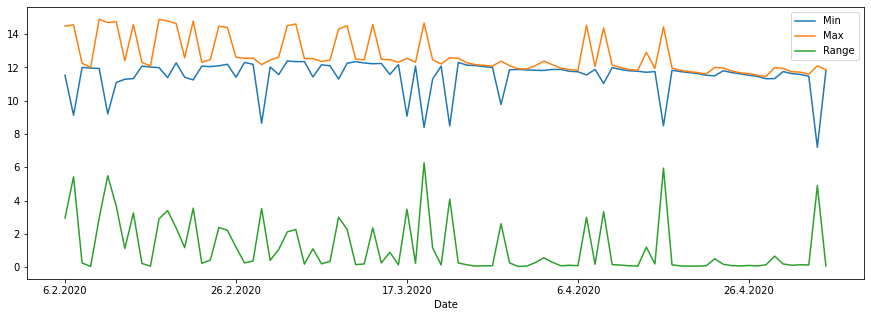

In [0]:
#df['ds'] = pd.to_datetime(df['Day'],  dayfirst = True)
df.plot(x='Date',   figsize=(15, 5))


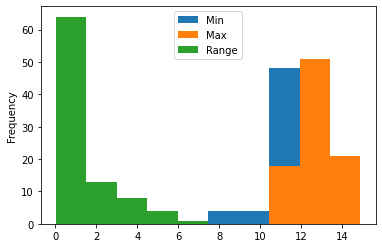

In [0]:
df.plot.hist()

# Prediction Method 1: Facebook's Prophet Model

As a prediction method, we will use Prophet. 

[More about Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) 




## Prepare a Train & Predict function for  the Prophet Model


In [0]:
def prediction_Prophet(feature):
  dfNew = pd.DataFrame()
  dfNew['ds'] = pd.to_datetime(df['Date'],  dayfirst = True)
  dfNew['y'] = df[[feature]].copy()
  
  #print(dfNew.tail())

  m = Prophet(daily_seasonality=True )
  m.fit(dfNew)
  horizon= 1
  future = m.make_future_dataframe(periods=horizon)
  forecast = m.predict(future)
  print('\nForcasted  {} values \n {}\n'.format(feature, forecast[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail()))
  fig1 = m.plot(forecast)
  #fig2 = m.plot_components(forecast)
  return forecast

## Run the Prophet Model

### For Range


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Forcasted  Range values 
            ds      yhat  yhat_lower  yhat_upper
86 2020-05-02 -0.302690   -2.213093    1.522619
87 2020-05-03 -0.372685   -2.203108    1.362113
88 2020-05-04  0.467312   -1.300845    2.272799
89 2020-05-05  0.908081   -0.922469    2.752685
90 2020-05-06 -0.010422   -1.740018    1.753628

Anamolies for range values
          Date        Day  Range  Range_By_Prophet
1    7.2.2020   Thursday   5.43          4.109406
5   11.2.2020     Monday   5.49          4.517128
6   12.2.2020  Wednesday   3.65          3.521432
23  29.2.2020   Saturday   3.52          2.913200
42  19.3.2020   Thursday   6.27          3.606529
45  22.3.2020     Sunday   4.09          2.313134
51  28.3.2020   Saturday   2.61          2.132853
63   9.4.2020     Friday   3.33          3.034327
70  16.4.2020   Thursday   5.95          2.927755
88   4.5.2020     Sunday   4.90          2.272799


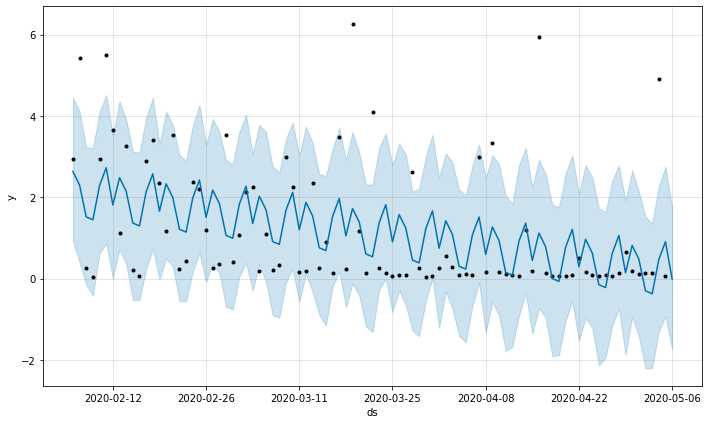

In [0]:
pred=prediction_Prophet('Range')

df['Range_By_Prophet']=pred['yhat_upper']

print('Anamolies for range values\n', df[df['Range']>df['Range_By_Prophet']][['Date','Day','Range','Range_By_Prophet']])

### For Min Values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Forcasted  Min values 
            ds       yhat  yhat_lower  yhat_upper
86 2020-05-02  11.402351   10.130910   12.695916
87 2020-05-03  11.447742   10.165863   12.635703
88 2020-05-04  11.347698   10.010957   12.593355
89 2020-05-05  11.297671    9.997330   12.550982
90 2020-05-06  11.703504   10.469887   13.079665

Anamolies for min values
          Date       Day   Min  Min_By_Prophet
1    7.2.2020  Thursday  9.13       10.288794
5   11.2.2020    Monday  9.21       10.199583
23  29.2.2020  Saturday  8.65       10.296754
40  17.3.2020   Tuesday  9.07       10.186316
42  19.3.2020  Thursday  8.40       10.034255
45  22.3.2020    Sunday  8.49       10.279264
51  28.3.2020  Saturday  9.77       10.173073
70  16.4.2020  Thursday  8.49        9.817266
88   4.5.2020    Sunday  7.20       10.010957


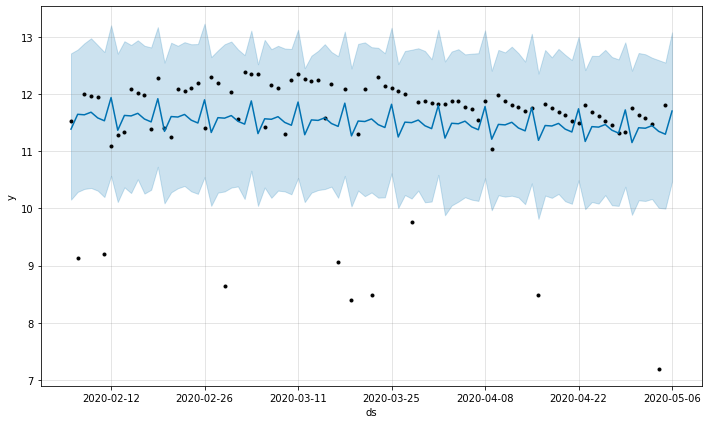

In [0]:
pred=prediction_Prophet('Min')

df['Min_By_Prophet']=pred['yhat_lower']
print('Anamolies for min values\n', df[df['Min']<df['Min_By_Prophet']][['Date','Day','Min','Min_By_Prophet']])


### For Max values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Forcasted  Max values 
            ds       yhat  yhat_lower  yhat_upper
86 2020-05-02  11.092667   10.078668   12.056792
87 2020-05-03  11.068083   10.054748   12.104369
88 2020-05-04  11.812584   10.852998   12.876758
89 2020-05-05  12.205813   11.192589   13.168699
90 2020-05-06  11.689980   10.634107   12.671430

Anamolies for Max values
          Date        Day    Max  Max_By_Prophet
4   10.2.2020     Friday  14.89       14.858076
6   12.2.2020  Wednesday  14.75       14.740486
11  17.2.2020     Monday  14.89       14.641376
13  19.2.2020  Wednesday  14.64       14.501172
15  21.2.2020     Friday  14.79       14.601317
18  24.2.2020     Monday  14.48       14.443966
27   4.3.2020     Friday  14.61       14.217147
32   9.3.2020   Thursday  14.30       14.145933
36  13.3.2020     Friday  14.58       14.038549
42  19.3.2020   Thursday  14.67       13.967375
61   7.4.2020   Saturday  14.54       13.923903
63   9.4.2020     Friday  14.37       13.512200
70  16.4.2020   Thursday  14.4

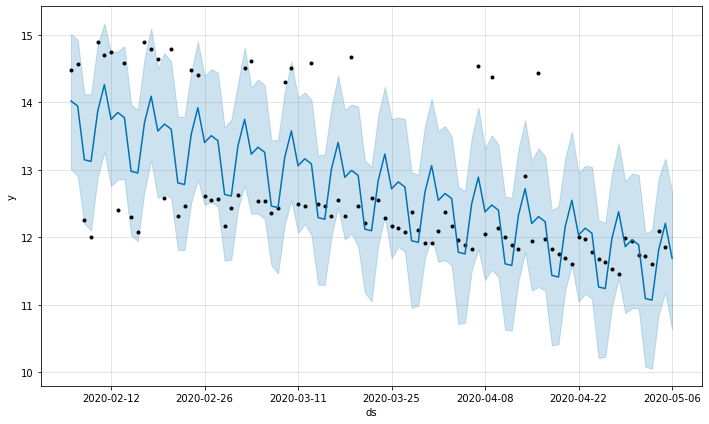

In [0]:
pred=prediction_Prophet('Max')

df['Max_By_Prophet']=pred['yhat_upper']
print('Anamolies for Max values\n', df[df['Max']>df['Max_By_Prophet']][['Date','Day','Max','Max_By_Prophet']])

## Compare the predictions with collected data 


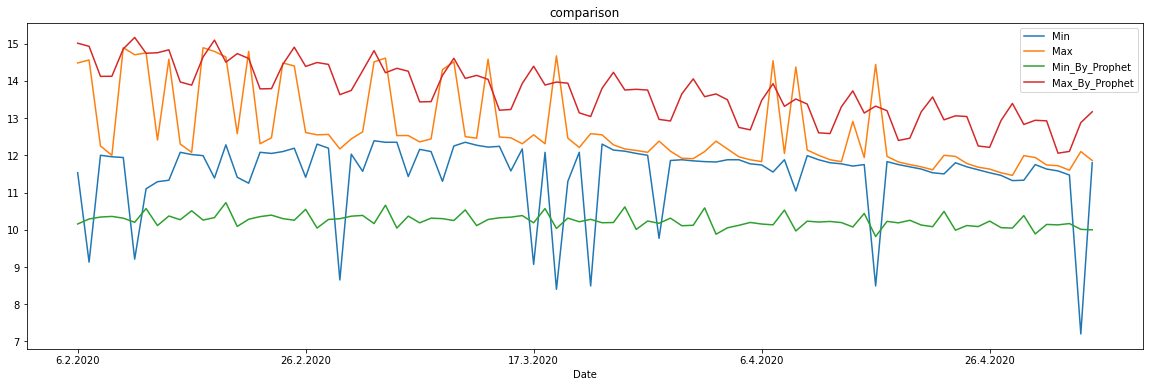

In [0]:
df.plot(title="comparison",x='Date',y=['Min','Max', 'Min_By_Prophet','Max_By_Prophet'],figsize=(20, 6))

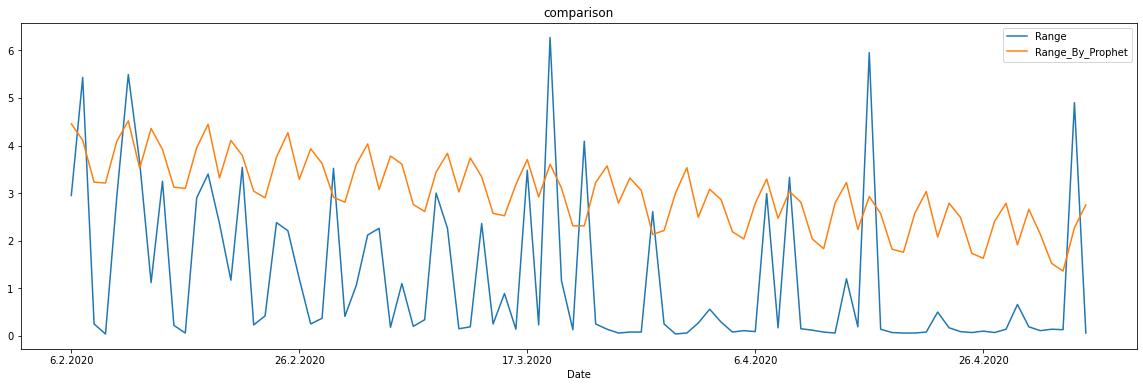

In [0]:
df.plot(title="comparison",x='Date',y=['Range','Range_By_Prophet'],figsize=(20, 6))

#Prediction Method 2: Mean + 2 SD
[More about Normal distribution & Standard Deviation](https://anomaly.io/anomaly-detection-normal-distribution/index.html) 
## Key Concepts:
* A **normal distribution** is a very common probability distribution that approximates the behavior of many natural phenomena.

* The **standard deviation**, called sigma (σ), defines how far the normal distribution is spread around the mean.

## Mathematical Rules:

When a metric is normally distributed it follows some interesting laws:

* The **mean** and the **median** are the same: both are equal to 1000 in this case. This is because of the perfectly symmetric “bell-shape”.

* The standard deviation, called sigma (σ), in this example σ = 20.
* 68% of all values fall between [mean-σ, mean+σ]; for the example this is [980, 1020].
* 95% of all values fall between [mean-2*σ, mean+2*σ]; for the example, [960, 1040].
* 99,7% of all values fall between [mean-3*σ, mean+3*σ]; in the example, [940; 1060].

The last 3 rules are also known as the **68–95–99.7 rule** or the “**three-sigma rule of thumb**”.



<img border="0" alt="W3Schools" src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/3-sigma-rules.png?raw=true" width="500" height="500">



### For Min

In [0]:
print('Mean of Min', df['Min'].mean())
print('Standart Deviation of Min', df['Min'].std())
print('Expected minimum value for of Min', df['Min'].mean()-2*df['Min'].std())
df['Min_Calculated']=df['Min'].mean()-2*df['Min'].std()
print('Anamolies for Min values\n', df[df['Min']<df['Min_Calculated']][['Date','Day','Min','Min_Calculated']])

Mean of Min 11.510000000000002
Standart Deviation of Min 1.0123506964408477
Expected minimum value for of Min 9.485298607118306
Anamolies for Min values
          Date       Day   Min  Min_Calculated
1    7.2.2020  Thursday  9.13        9.485299
5   11.2.2020    Monday  9.21        9.485299
23  29.2.2020  Saturday  8.65        9.485299
40  17.3.2020   Tuesday  9.07        9.485299
42  19.3.2020  Thursday  8.40        9.485299
45  22.3.2020    Sunday  8.49        9.485299
70  16.4.2020  Thursday  8.49        9.485299
88   4.5.2020    Sunday  7.20        9.485299


### For Max

In [0]:
print('Mean of Max', df['Max'].mean())
print('Standart Deviation of Max', df['Max'].std())
print('Expected minimum value for of Max', df['Max'].mean()+2*df['Max'].std())
df['Max_Calculated']=df['Max'].mean()+2*df['Max'].std()
print('Anamolies for Max values\n', df[df['Max']>df['Max_Calculated']][['Date','Day','Max','Max_Calculated']])

Mean of Max 12.716444444444445
Standart Deviation of Max 1.0829364066850118
Expected minimum value for of Max 14.882317257814469
Anamolies for Max values
          Date     Day    Max  Max_Calculated
4   10.2.2020  Friday  14.89       14.882317
11  17.2.2020  Monday  14.89       14.882317


### For Range

In [0]:
print('Mean of Range', df['Range'].mean())
print('Standart Deviation of Range', df['Range'].std())
maxRange=df['Range'].mean()+2*df['Range'].std()
print('Expected maximum value for of Range', maxRange)
df['Range_Calculated']=maxRange
print('Anamolies for Range values\n', df[df['Range']>df['Range_Calculated']][['Date','Day','Range','Range_Calculated']])

Mean of Range 1.2064444444444447
Standart Deviation of Range 1.5983251846089728
Expected maximum value for of Range 4.40309481366239
Anamolies for Range values
          Date       Day  Range  Range_Calculated
1    7.2.2020  Thursday   5.43          4.403095
5   11.2.2020    Monday   5.49          4.403095
42  19.3.2020  Thursday   6.27          4.403095
70  16.4.2020  Thursday   5.95          4.403095
88   4.5.2020    Sunday   4.90          4.403095


## Compare the predictions with collected data 

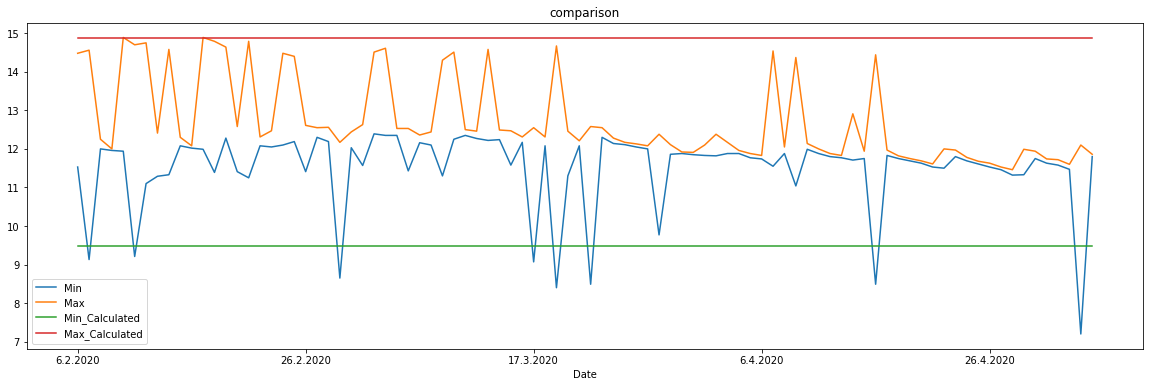

In [0]:
df.plot(title="comparison",x='Date',y=['Min','Max', 'Min_Calculated','Max_Calculated'],figsize=(20, 6))


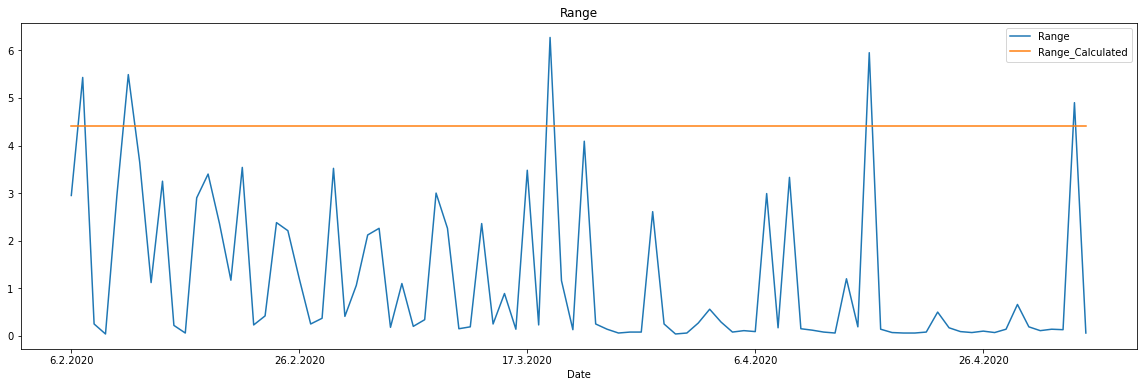

In [0]:
df.plot(title="Range",x='Date',y=['Range','Range_Calculated'],figsize=(20, 6))

# Summary


In [0]:
def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])
CodesOfInterest=['anomaly']
def showSummary(fontSize='12px'):
  summary =pd.DataFrame()
  CodesOfInterest=['anomaly']
  summary= anomaly[(anomaly.isin(CodesOfInterest)==True).any(1)]
  styles = [
    hover(),
    dict(selector="th", props=[("font-size", fontSize),
                               ("text-align", "center")]),
    dict(selector="tr", props=[("font-size", fontSize),
                               ("text-align", "center")]),      
    dict(selector="caption", props=[("caption-side", "bottom")])
  ]
  html = (summary.style.set_table_styles(styles)
          .set_caption("Hover to highlight."))
  print(' Number of detected anomalies: ', len(summary) )
  return html

In [0]:
anomaly = pd.DataFrame()
anomaly = df[['Date','Day','Min','Max','Range']].copy()
anomaly['Min_anomaly_Prophet']= df['Min']
anomaly['Max_anomaly_Prophet']= df['Max']
anomaly['Range_anomaly_Prophet']=df['Range']

anomaly['Min_anomaly_Calculated']= df['Min']
anomaly['Max_anomaly_Calculated']= df['Max']
anomaly['Range_anomaly_Calculated']= df['Range']


In [0]:
df.columns

Index(['Date', 'Day', 'Min', 'Max', 'Range', 'Range_By_Prophet',
       'Min_By_Prophet', 'Max_By_Prophet', 'Min_Calculated', 'Max_Calculated',
       'Range_Calculated'],
      dtype='object')

In [0]:
anomaly['Min_anomaly_Prophet'][df['Min']<df['Min_By_Prophet']]= 'anomaly'
anomaly['Min_anomaly_Prophet'][df['Min']>=df['Min_By_Prophet']]= ''

anomaly['Max_anomaly_Prophet'][df['Max']>df['Max_By_Prophet']]= 'anomaly'
anomaly['Max_anomaly_Prophet'][df['Max']<=df['Max_By_Prophet']]= ''

anomaly['Range_anomaly_Prophet'][df['Range']>df['Range_By_Prophet']]= 'anomaly'
anomaly['Range_anomaly_Prophet'][df['Range']<=df['Range_By_Prophet']]= ''

anomaly['Min_anomaly_Calculated'][df['Min']<df['Min_Calculated']]= 'anomaly'
anomaly['Min_anomaly_Calculated'][df['Min']>=df['Min_Calculated']]= ''

anomaly['Max_anomaly_Calculated'][df['Max']>df['Max_Calculated']]= 'anomaly'
anomaly['Max_anomaly_Calculated'][df['Max']<=df['Max_Calculated']]= ''

anomaly['Range_anomaly_Calculated'][df['Range']>df['Range_Calculated']]= 'anomaly'
anomaly['Range_anomaly_Calculated'][df['Range']<=df['Range_Calculated']]= ''




In [0]:
showSummary('11px')


 Number of detected anomalies:  20


,Date,Day,Min,Max,Range,Min_anomaly_Prophet,Max_anomaly_Prophet,Range_anomaly_Prophet,Min_anomaly_Calculated,Max_anomaly_Calculated,Range_anomaly_Calculated
1,7.2.2020,Thursday,9.130000,14.560000,5.430000,anomaly,,anomaly,anomaly,,anomaly
4,10.2.2020,Friday,11.940000,14.890000,2.950000,,anomaly,,,anomaly,
5,11.2.2020,Monday,9.210000,14.700000,5.490000,anomaly,,anomaly,anomaly,,anomaly
6,12.2.2020,Wednesday,11.100000,14.750000,3.650000,,anomaly,anomaly,,,
11,17.2.2020,Monday,11.990000,14.890000,2.900000,,anomaly,,,anomaly,
13,19.2.2020,Wednesday,12.280000,14.640000,2.360000,,anomaly,,,,
15,21.2.2020,Friday,11.250000,14.790000,3.540000,,anomaly,,,,
18,24.2.2020,Monday,12.100000,14.480000,2.380000,,anomaly,,,,
23,29.2.2020,Saturday,8.650000,12.170000,3.520000,anomaly,,anomaly,anomaly,,
27,4.3.2020,Friday,12.350000,14.610000,2.260000,,anomaly,,,,


# Prediction Method 3: Simple Moving Average (SMA)


Let's calculate Simple Moving Average with 3 days window


## Prepare a Train & Predict function for SMA


In [0]:
def predict_SMA(feature):
  window= 7
  sma = df[feature].rolling(window=window).mean()
  rstd = df[feature].rolling(window=window).std()
  bands = pd.DataFrame()
  bands['Date']=  (df['Date']).copy()
  bands['Date'] = pd.to_datetime(bands['Date'], dayfirst=True)
  bands['sma'] = sma 
  bands['lower'] = sma - 2 * rstd
  bands['upper'] = sma + 2 * rstd
  bands = bands.join(df[feature])
  bands = bands.set_index('Date')
  fig = plt.figure(figsize=(20, 6))
  ax = bands.plot(title=feature,  figsize=(20, 6))
  ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
  ax.set_xlabel('Date')
  ax.set_ylabel(feature)
  ax.grid()
  plt.show()
  return bands

## For Min 


<Figure size 1440x432 with 0 Axes>

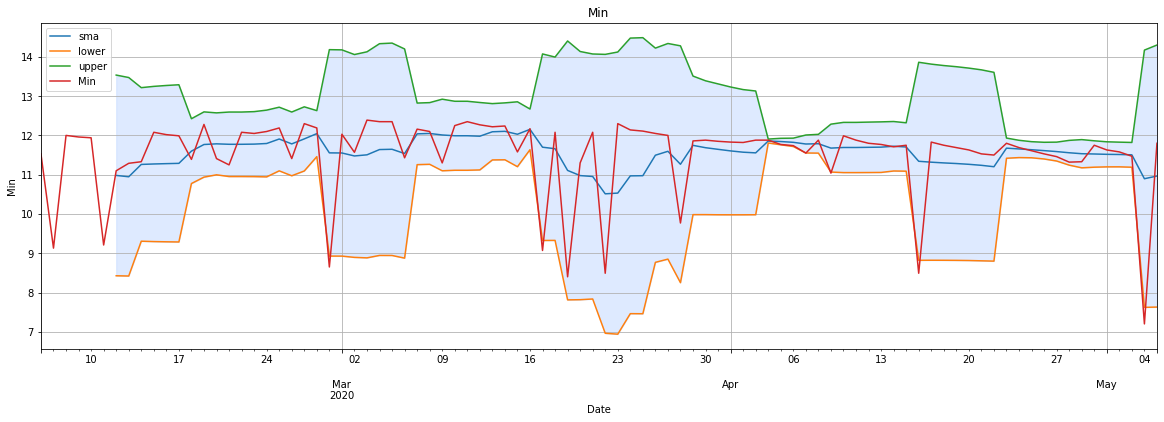

Anamolies for SMA_Min values
          Date    Min    Min_SMA
23  29.2.2020   8.65   8.927208
40  17.3.2020   9.07   9.324907
61   7.4.2020  11.55  11.552393
63   9.4.2020  11.04  11.067147
70  16.4.2020   8.49   8.819778
88   4.5.2020   7.20   7.621583


In [0]:
bands = predict_SMA('Min')
bands.reset_index(inplace=True)
min= df['Min'].min()
bands['lower'].fillna(min , inplace=True)
df['Min_SMA']= bands['lower'].copy()
print('Anamolies for SMA_Min values\n', df[df['Min']<df['Min_SMA']][['Date','Min', 'Min_SMA']])



## For Max 


<Figure size 1440x432 with 0 Axes>

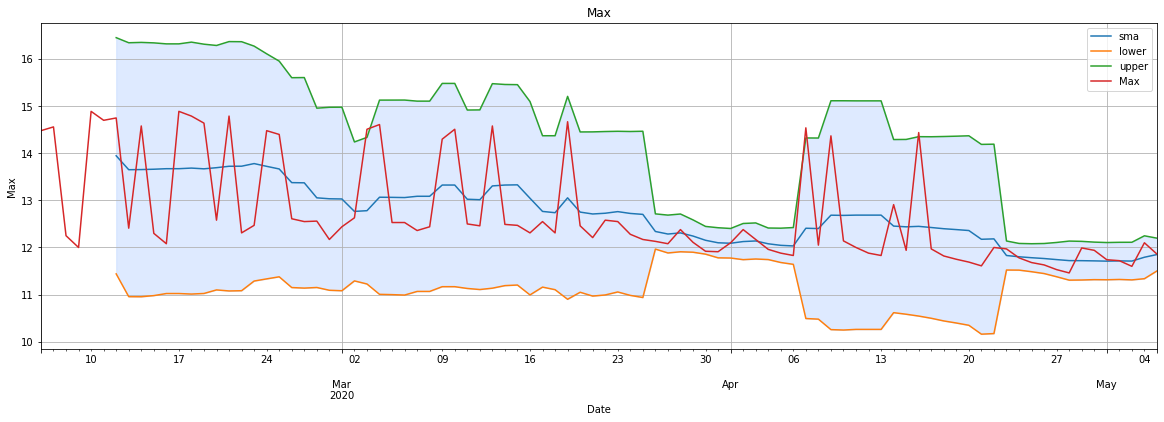

Anamolies for Max_SMA values
          Date    Max    Max_SMA
26   3.3.2020  14.51  14.337767
61   7.4.2020  14.54  14.325389
70  16.4.2020  14.44  14.352897


In [0]:
bands = predict_SMA('Max')
bands.reset_index(inplace=True)
max= df['Max'].max()
bands['upper'].fillna(max , inplace=True)

df['Max_SMA']= bands['upper'].copy()
print('Anamolies for Max_SMA values\n', df[df['Max']>df['Max_SMA']][['Date','Max', 'Max_SMA']])

## For Range

<Figure size 1440x432 with 0 Axes>

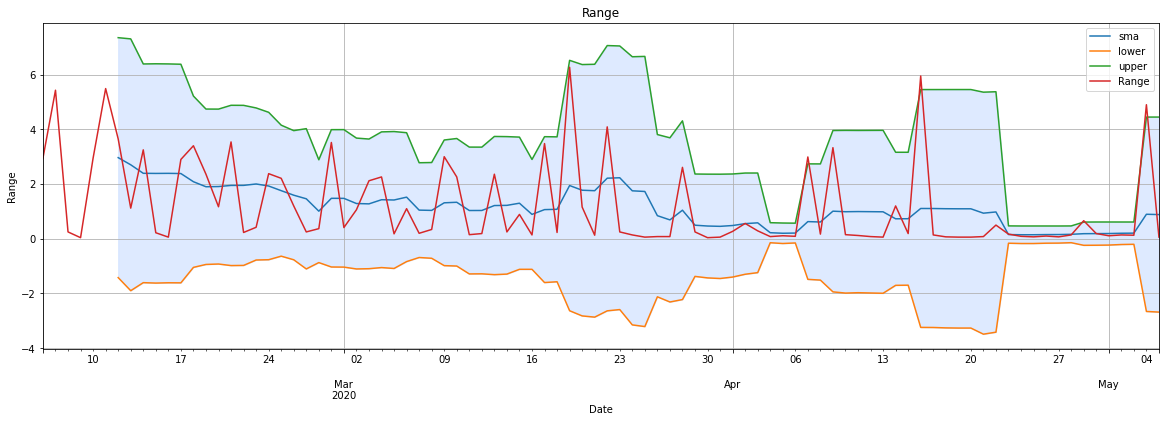

Anamolies for Range_SMA values
          Date  Range  Range_SMA
61   7.4.2020   2.99   2.738089
70  16.4.2020   5.95   5.454183
83  29.4.2020   0.66   0.610427
88   4.5.2020   4.90   4.448532


In [0]:
bands = predict_SMA('Range')
bands.reset_index(inplace=True)
max= df['Range'].max()
bands['upper'].fillna(max , inplace=True)
df['Range_SMA']= bands['upper'].copy()
print('Anamolies for Range_SMA values\n', df[df['Range']>=df['Range_SMA']][['Date','Range', 'Range_SMA']])

#Summary

In [0]:
anomaly['Min_anomaly_SMA']= df['Min']
anomaly['Max_anomaly_SMA']= df['Max']
anomaly['Range_anomaly_SMA']= df['Range']

anomaly['Min_anomaly_SMA'][df['Min']<df['Min_SMA']]= 'anomaly'
anomaly['Min_anomaly_SMA'][df['Min']>=df['Min_SMA']]= ''

anomaly['Max_anomaly_SMA'][df['Max']>df['Max_SMA']]= 'anomaly'
anomaly['Max_anomaly_SMA'][df['Max']<=df['Max_SMA']]= ''

anomaly['Range_anomaly_SMA'][df['Range']>df['Range_SMA']]= 'anomaly'
anomaly['Range_anomaly_SMA'][df['Range']<=df['Range_SMA']]= ''


In [0]:
showSummary('10px')

 Number of detected anomalies:  22


,Date,Day,Min,Max,Range,Min_anomaly_Prophet,Max_anomaly_Prophet,Range_anomaly_Prophet,Min_anomaly_Calculated,Max_anomaly_Calculated,Range_anomaly_Calculated,Min_anomaly_SMA,Max_anomaly_SMA,Range_anomaly_SMA
1,7.2.2020,Thursday,9.130000,14.560000,5.430000,anomaly,,anomaly,anomaly,,anomaly,,,
4,10.2.2020,Friday,11.940000,14.890000,2.950000,,anomaly,,,anomaly,,,,
5,11.2.2020,Monday,9.210000,14.700000,5.490000,anomaly,,anomaly,anomaly,,anomaly,,,
6,12.2.2020,Wednesday,11.100000,14.750000,3.650000,,anomaly,anomaly,,,,,,
11,17.2.2020,Monday,11.990000,14.890000,2.900000,,anomaly,,,anomaly,,,,
13,19.2.2020,Wednesday,12.280000,14.640000,2.360000,,anomaly,,,,,,,
15,21.2.2020,Friday,11.250000,14.790000,3.540000,,anomaly,,,,,,,
18,24.2.2020,Monday,12.100000,14.480000,2.380000,,anomaly,,,,,,,
23,29.2.2020,Saturday,8.650000,12.170000,3.520000,anomaly,,anomaly,anomaly,,,anomaly,,
26,3.3.2020,Tuesday,12.390000,14.510000,2.120000,,,,,,,,anomaly,


# Prediction Method 4: Exponential Moving Average (EMA)

EMA(t)

EMA(t0)=(1−α)

EMA(t−1)+α p(t)=p(t0)
 
where p(t) is the price at time t and α is called the decay parameter for the EMA. 

α is related to the lag as
α=1/L+1

and the length of the window (span) M as
α=2/M+1.

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by 1/M.


## Prepare a Train & Predict function for SMA

In [0]:
def predict_EMA(feature):
  window= 3
  ema = df[feature].ewm(span=window,adjust=False).mean()
  rstd = df[feature].rolling(window=window).std()
  bands = pd.DataFrame()
  bands['Date']=  (df['Date']).copy()
  bands['Date'] = pd.to_datetime(bands['Date'], dayfirst=True)
  bands['ema'] = ema 
  bands['lower'] = ema - 2 * rstd
  bands['upper'] = ema + 2 * rstd
  bands = bands.join(df[feature])
  bands = bands.set_index('Date')
  fig = plt.figure(figsize=(20, 6))
  ax = bands.plot(title=feature,  figsize=(20, 6))
  ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
  ax.set_xlabel('Date')
  ax.set_ylabel(feature)
  ax.grid()
  plt.show()
  return bands

## For Min

<Figure size 1440x432 with 0 Axes>

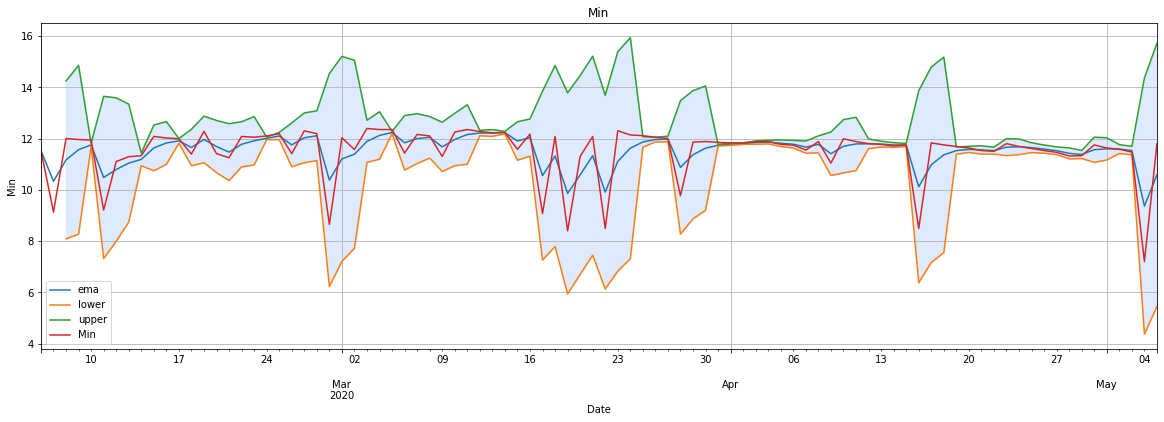

Anamolies for EMA_Min values
 Empty DataFrame
Columns: [Date, Min, Min_EMA]
Index: []


In [0]:
bands= predict_EMA('Min')
bands.reset_index(inplace=True)
min= df['Min'].min()
bands['lower'].fillna(min , inplace=True)
df['Min_EMA']= bands['lower'].copy()
print('Anamolies for EMA_Min values\n', df[df['Min']<df['Min_EMA']][['Date','Min', 'Min_EMA']])

## For Max

<Figure size 1440x432 with 0 Axes>

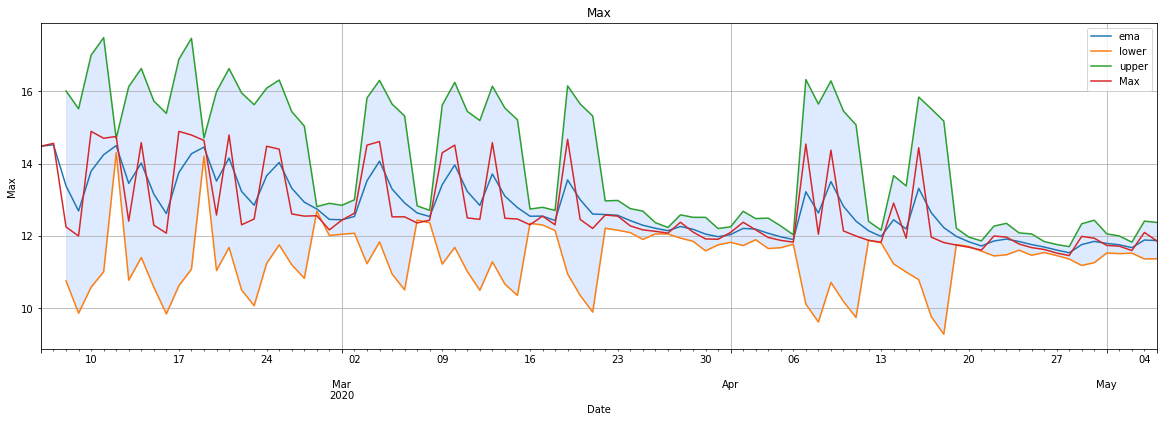

Anamolies for EMA_Max values
         Date    Max   Max_EMA
6  12.2.2020  14.75  14.69479


In [0]:
bands = predict_EMA('Max')
bands.reset_index(inplace=True)
max= df['Max'].max()
bands['upper'].fillna(max , inplace=True)
df['Max_EMA']= bands['upper'].copy()
print('Anamolies for EMA_Max values\n', df[df['Max']>df['Max_EMA']][['Date','Max', 'Max_EMA']])

## For Range

<Figure size 1440x432 with 0 Axes>

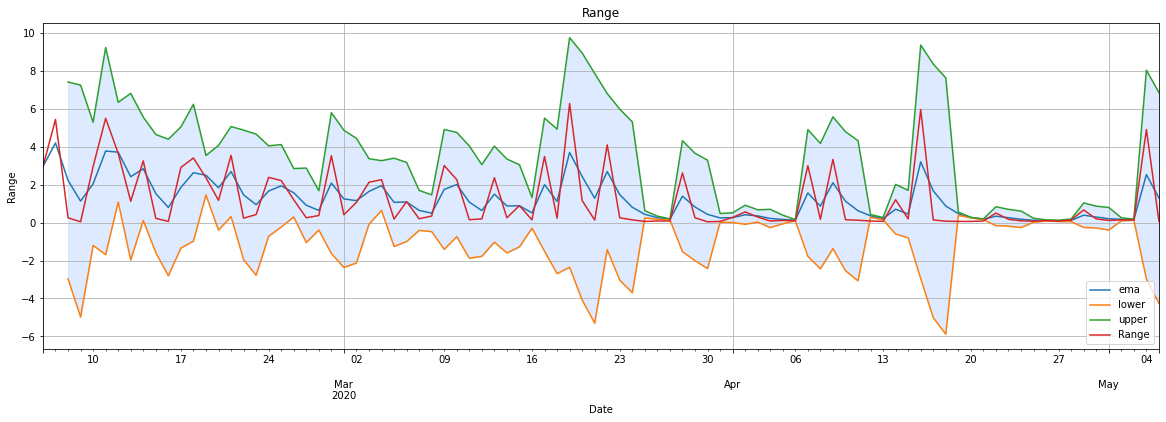

Anamolies for EMA_Range values
 Empty DataFrame
Columns: [Date, Range, Range_EMA]
Index: []


In [0]:
bands = predict_EMA('Range')
bands.reset_index(inplace=True)
max= df['Range'].max()
bands['upper'].fillna(max , inplace=True)
df['Range_EMA']= bands['upper'].copy()
print('Anamolies for EMA_Range values\n', df[df['Range']>df['Range_EMA']][['Date','Range', 'Range_EMA']])

#Summary


In [0]:
anomaly['Min_anomaly_EMA']= df['Min']
anomaly['Max_anomaly_EMA']= df['Max']
anomaly['Range_anomaly_EMA']= df['Range']

anomaly['Min_anomaly_EMA'][df['Min']<df['Min_EMA']]= 'anomaly'
anomaly['Min_anomaly_EMA'][df['Min']>=df['Min_EMA']]= ''

anomaly['Max_anomaly_EMA'][df['Max']>df['Max_EMA']]= 'anomaly'
anomaly['Max_anomaly_EMA'][df['Max']<=df['Max_EMA']]= ''

anomaly['Range_anomaly_EMA'][df['Range']>df['Range_EMA']]= 'anomaly'
anomaly['Range_anomaly_EMA'][df['Range']<=df['Range_EMA']]= ''

In [0]:
showSummary('9px')

 Number of detected anomalies:  22


,Date,Day,Min,Max,Range,Min_anomaly_Prophet,Max_anomaly_Prophet,Range_anomaly_Prophet,Min_anomaly_Calculated,Max_anomaly_Calculated,Range_anomaly_Calculated,Min_anomaly_SMA,Max_anomaly_SMA,Range_anomaly_SMA,Min_anomaly_EMA,Max_anomaly_EMA,Range_anomaly_EMA
1,7.2.2020,Thursday,9.130000,14.560000,5.430000,anomaly,,anomaly,anomaly,,anomaly,,,,,,
4,10.2.2020,Friday,11.940000,14.890000,2.950000,,anomaly,,,anomaly,,,,,,,
5,11.2.2020,Monday,9.210000,14.700000,5.490000,anomaly,,anomaly,anomaly,,anomaly,,,,,,
6,12.2.2020,Wednesday,11.100000,14.750000,3.650000,,anomaly,anomaly,,,,,,,,anomaly,
11,17.2.2020,Monday,11.990000,14.890000,2.900000,,anomaly,,,anomaly,,,,,,,
13,19.2.2020,Wednesday,12.280000,14.640000,2.360000,,anomaly,,,,,,,,,,
15,21.2.2020,Friday,11.250000,14.790000,3.540000,,anomaly,,,,,,,,,,
18,24.2.2020,Monday,12.100000,14.480000,2.380000,,anomaly,,,,,,,,,,
23,29.2.2020,Saturday,8.650000,12.170000,3.520000,anomaly,,anomaly,anomaly,,,anomaly,,,,,
26,3.3.2020,Tuesday,12.390000,14.510000,2.120000,,,,,,,,anomaly,,,,


In [0]:
anomaly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      90 non-null     object 
 1   Day                       90 non-null     object 
 2   Min                       90 non-null     float64
 3   Max                       90 non-null     float64
 4   Range                     90 non-null     float64
 5   Min_anomaly_Prophet       90 non-null     object 
 6   Max_anomaly_Prophet       90 non-null     object 
 7   Range_anomaly_Prophet     90 non-null     object 
 8   Min_anomaly_Calculated    90 non-null     object 
 9   Max_anomaly_Calculated    90 non-null     object 
 10  Range_anomaly_Calculated  90 non-null     object 
 11  Min_anomaly_SMA           90 non-null     object 
 12  Max_anomaly_SMA           90 non-null     object 
 13  Range_anomaly_SMA         90 non-null     object 
 14  Min_anomaly_

         Date        Day  Vote_Number
1    7.2.2020   Thursday            4
4   10.2.2020     Friday            2
5   11.2.2020     Monday            4
6   12.2.2020  Wednesday            2
11  17.2.2020     Monday            2
13  19.2.2020  Wednesday            1
15  21.2.2020     Friday            1
18  24.2.2020     Monday            1
23  29.2.2020   Saturday            4
26   3.3.2020    Tuesday            1
27   4.3.2020     Friday            1
32   9.3.2020   Thursday            1
36  13.3.2020     Friday            1
40  17.3.2020    Tuesday            3
42  19.3.2020   Thursday            5
45  22.3.2020     Sunday            3
51  28.3.2020   Saturday            2
61   7.4.2020   Saturday            4
63   9.4.2020     Friday            3
70  16.4.2020   Thursday            8
83  29.4.2020  Wednesday            1
88   4.5.2020     Sunday            6


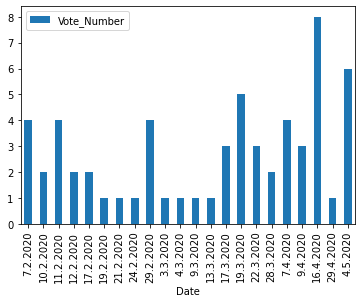

In [0]:
anomaly=anomaly[(anomaly.isin(CodesOfInterest)==True).any(1)]

#Apply pd.Series.value_counts to all the columns of the dataframe, it will give you the count of unique values for each row
voting= anomaly.iloc[:,5:14].apply(pd.Series.value_counts, axis=1)
voting.iloc[:,1:2]
anomaly['Vote_Number']=voting.iloc[:,1:2]
anomaly['Vote_Ratio']=voting.iloc[:,1:2]/9*100
anomaly.plot.bar(x='Date', y='Vote_Number')
print(anomaly[['Date','Day', 'Vote_Number']])

In [0]:
print("Total Number of detected anomalies: ",len(anomaly))
threshold= 50
print("Number of Anomalies over the threshold ({}%) voting: {} ".format(threshold,len(anomaly[anomaly['Vote_Ratio']>threshold] )))
print(anomaly[anomaly['Vote_Ratio']>threshold][['Date','Day','Vote_Number','Min','Max','Range']])

Total Number of detected anomalies:  22
Number of Anomalies over the threshold (50%) voting: 3 
         Date       Day  Vote_Number   Min    Max  Range
42  19.3.2020  Thursday            5  8.40  14.67   6.27
70  16.4.2020  Thursday            8  8.49  14.44   5.95
88   4.5.2020    Sunday            6  7.20  12.10   4.90


In [0]:
anomaly['Vote_Number'].describe()

count    22.000000
mean      2.727273
std       1.906925
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       8.000000
Name: Vote_Number, dtype: float64

# Export the Anomaly Report

In [0]:
anomaly.to_csv('anomaly.csv')

# Conclusion

Given the data set and using the Prophet, SMA, EMA to forecast the anomaly:
* Data has ONLY **90 days**
* Majority Voting provides a fitering mechanism of the predicted anomalies by various methods
* We analyze the anomaly in a day by using 3 observation: **min, max, and range** values of current in mA.
* The four selected methods detected **22 anomalies** out of 90 data samples
* **EMA** has predicted almost no anomalies
* Thus, we remove it, only use the rest **three methods** in Majority Voting
* We decided that there are **3 anomalies** by setting the Majority Voting **threshold 50%**


# How you can improve
* Add more prediction methods such as:

>* [Arima](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
>*  [Autoregressive (AR)](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/) 
>* [Self Organizing Maps](https://towardsdatascience.com/self-organizing-maps-ff5853a118d4)

* Implement Weighted Voting scheme

* Apply what you have learned in here to a different data set

* Write a comment to me


# Thank you
Murat Karakaya

First Submission: 09/05/2020